# SMB figures for the state of the climate report. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as colors
from palettable.colorbrewer.sequential import *
from palettable.cmocean.sequential import *
from palettable.colorbrewer.diverging import *
from calendar import monthrange
from scipy import stats
import geopandas as gpd
import pandas as pd

## Define utility functions

In [2]:
def calc_seconds_in_month(year, month):
    days = monthrange(year, month)[1]
    seconds_in_month = days * 24 * 60 * 60
    return seconds_in_month

def calc_seconds_in_year(year):
    seconds = 0
    for month in range(1, 13):
        seconds = seconds + calc_seconds_in_month(year, month)
    return seconds

def calc_monthly_smb(monthly_data_path, year):
    
    # Precipitation
    sn = xr.open_dataset(monthly_data_path + "PRECSN_monthly_" + str(year) + ".nc")
    ls = xr.open_dataset(monthly_data_path + "PRECLS_monthly_" + str(year) + ".nc")
    cu = xr.open_dataset(monthly_data_path + "PRECCU_monthly_" + str(year) + ".nc")

    # Evaporation 
    evap = xr.open_dataset(monthly_data_path + "EVAP_monthly_" + str(year) + ".nc")
    
    # SMB 
    monthly_smb = sn['PRECSN'] + ls['PRECLS'] + cu['PRECCU'] - evap['EVAP']
    
    # Return output (units: kg/m^2/s)
    return monthly_smb

def calc_annual_smb(monthly_data_path, year):
    monthly_smb = calc_monthly_smb(monthly_data_path, year)
    annual_smb = monthly_smb.mean(dim='month')
    annual_smb = annual_smb * calc_seconds_in_year(year)
    
    # Return output (units: kg/m^2/year)
    return annual_smb

def calc_grounded_smb(monthly_data_path, year):
    '''
    Calculate SMB over only the grounded ice sheet. 
    '''
    grounded_mask = xr.open_dataset("data/AIS_Grounded_basins_Zwally_MERRA2grid.nc")
    grounded_mask = grounded_mask['Zwallybasins'] / grounded_mask['Zwallybasins']
    smb = calc_annual_smb(monthly_data_path, year)
    grounded_smb = smb * grounded_mask
    
    # Return output (units: kg/m^2/year)
    return grounded_smb
    
    
def calc_AIS_smb(monthly_data_path, year):
    '''
    Calculate SMB over the entire ice sheet.  
    '''
    
    ais_mask = xr.open_dataset("data/AIS_basins_Zwally_MERRA2grid.nc")
    ais_mask = ais_mask['Zwallybasins'] / ais_mask['Zwallybasins']
    smb = calc_annual_smb(monthly_data_path, year)
    ais_smb = smb * ais_mask
    
    # Return output (units: kg/m^2/year)
    return ais_smb

def grid_cell_mass(smb):
    '''
    Convert smb values from kg/m^2/year to kg/grid cell/year by 
    multiplying by grid cell area (m^2). 
    '''
    
    # Grid Area
    ga = xr.open_dataset("data/MERRA2_gridarea.nc")
    ga = ga['cell_area'][0:101,:]
    
    # Return output (units: kg/grid cell/year)
    return smb * ga

def calc_monthly_grounded_smb(monthly_data_path, year): 
    '''
    Calculate the integrated grounded smb for each month of the year
    '''
    seconds_in_month = np.zeros(12); seconds_in_month[:] = np.nan
    for month in range(0, len(seconds_in_month)):
        seconds_in_month[month] = calc_seconds_in_month(year, month + 1)
    
    monthly_smb = calc_monthly_smb(monthly_data_path, year)
    grounded_mask = xr.open_dataset("data/AIS_Grounded_basins_Zwally_MERRA2grid.nc")
    grounded_mask = grounded_mask['Zwallybasins'] / grounded_mask['Zwallybasins']
    grounded_monthly_smb = monthly_smb * grounded_mask
    grounded_monthly_smb = grid_cell_mass(grounded_monthly_smb)
    grounded_monthly_smb = grounded_monthly_smb.sum(dim='lat').sum(dim='lon') * seconds_in_month / 1e12

    # Return output (units: Gt/month)
    return grounded_monthly_smb

# Time series of annual grounded SMB (Gt)

0 1980 2366.039630401939
1 1981 2463.1992343941665
2 1982 2277.729979196752
3 1983 2018.1907904770328
4 1984 2210.7644322423444
5 1985 2222.2375651223774
6 1986 1962.9286008976871
7 1987 1854.1466454902093
8 1988 2052.487965895697
9 1989 2103.160678763308
10 1990 2006.968662789931
11 1991 2143.8912961085744
12 1992 2302.7789400743764
13 1993 2195.232579461659
14 1994 2002.4620470891914
15 1995 2149.6254069120255
16 1996 2154.8427080360043
17 1997 2023.1532016456833
18 1998 2167.916104672369
19 1999 2074.55501853801
20 2000 2117.574162913565
21 2001 2262.873888766893
22 2002 2263.586943685068
23 2003 2085.0157043618524
24 2004 2276.358423957187
25 2005 2415.8209400060764
26 2006 2182.478167939774
27 2007 2138.316269529813
28 2008 2224.346264631121
29 2009 2292.78330761393
30 2010 2072.214446403536
31 2011 2168.500306668541
32 2012 2041.6865892749393
33 2013 2117.5678011433365
34 2014 1947.7368484182284
35 2015 2108.3324609103083
36 2016 2234.829397926995
37 2017 2055.7016259348416
38 20

<Figure size 432x288 with 0 Axes>

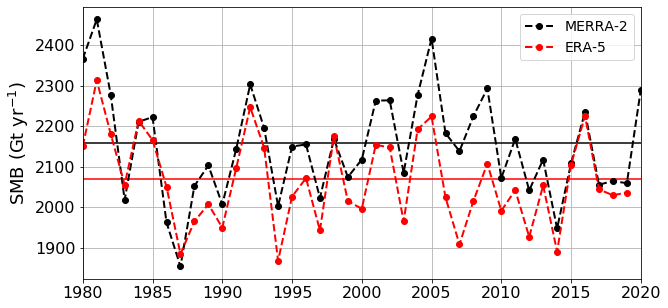

In [3]:
# Input parameters
year_start = 1980
year_end = 2020
monthly_data_path = "/scratch/summit/erke2265/MERRA2_monthly/"

# Initialize grounded smb arrays
M2_smb = np.zeros(year_end - year_start + 1); M2_smb[:] = np.nan
years = np.arange(year_start, year_end + 1)

# Calculate SMB for each year
for count, year in enumerate(years):
    grounded_smb = calc_grounded_smb(monthly_data_path, year)
    grounded_smb = grid_cell_mass(grounded_smb)
    M2_smb[count] = grounded_smb.sum() / 1e12 # Convert kg to Gt
    print(count, year, M2_smb[count])

# Get ERA-5
E5_smb = np.array(np.loadtxt('data/E5_Antartica_grounded_SMB_annual_total_ts_1980_2019.nc', delimiter=',',unpack=True))
E5_smb = np.append(E5_smb, np.nan) # Append 2020 value here once available. 

# Calculate 1981 - 2010 means
E5_1981_2010_mean = np.nanmean(E5_smb[1:31])
M2_1981_2010_mean = np.nanmean(M2_smb[1:31])

# Plot Timeseries
plt.figure()
fig1 = plt.figure(figsize = (10, 5))
year = np.arange(year_start, year_end + 1)
plt.plot(year, M2_smb, 'ko--', linewidth=2, label='MERRA-2')
plt.hlines(M2_1981_2010_mean, year_start, year_end, colors='k', linestyle='solid')
plt.plot(year, E5_smb, 'ro--', linewidth=2, label='ERA-5')
plt.hlines(E5_1981_2010_mean, year_start, year_end, colors='r', linestyle='solid')
plt.xlim([year_start, year_end])
plt.grid()
plt.legend(fontsize=14)
plt.ylabel("SMB (Gt yr$^{-1}$)", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figures/SMB_Timeseries.pdf', format='pdf', dpi=100)

-0.9563034336770877
2169.659041452674
-0.08858469003258121
0.58179681530033


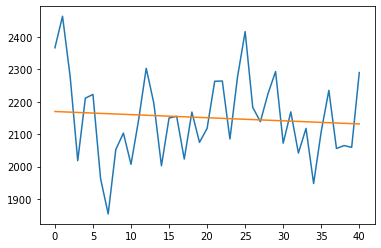

In [4]:
# Calculate linear trend in annual SMB
x = np.arange(0, len(years))
slope, intercept, r, p, se = stats.linregress(x, M2_smb)

# Plot linear regression
plt.plot(x, M2_smb)
plt.plot(x, intercept + slope * x)
print(slope)
print(intercept)
print(r)
print(p)

# Map of 2020 SMB (kg/m^2)

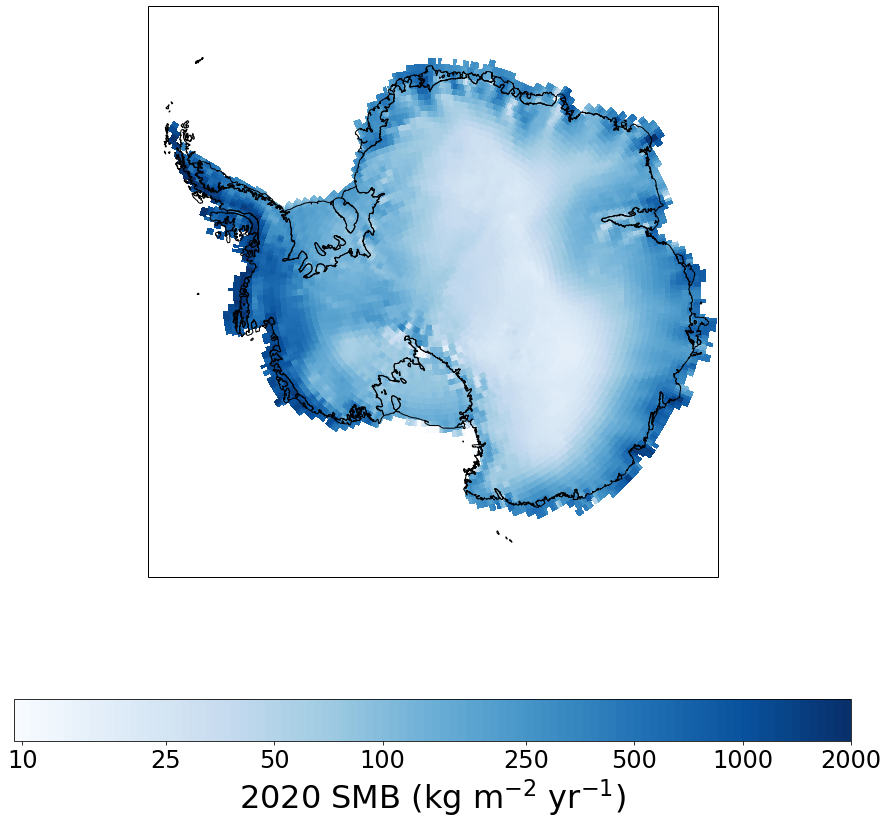

In [5]:
# Get map of 2020 SMB
monthly_data_path = "/scratch/summit/erke2265/MERRA2_monthly/"
year = 2020
ais_smb = calc_AIS_smb(monthly_data_path, year)

# Define lat and long
ds = xr.open_dataset(monthly_data_path + "T2M_monthly_1980.nc")

# Get coastlines
df = gpd.read_file("data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(15, 15))

# Plot SMB
colormap = Blues_9.mpl_colormap
boundaries = np.logspace(np.log10(10), np.log10(2000), 100)
boundaries = np.insert(boundaries, 0, 0)
norm = colors.BoundaryNorm(boundaries, colormap.N, clip=True)
mesh = plt.pcolormesh(np.linspace(-180, 180, len(ds['lon'])), ds['lat'].values, ais_smb.values, cmap=colormap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, orientation = 'horizontal', ticks = [10, 25, 50, 100, 250, 500, 1000, 2000])
cbar.set_label("2020 SMB (kg m$^{-2}$ yr$^{-1}$)", size = 32)
cbar.ax.tick_params(labelsize=24)

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Save figure
plt.savefig('figures/2020_AIS_MERRA2_SMB.pdf', format='pdf', dpi=100)

# Map of 2020 SMB Anomaly (%)

In [6]:
# Calculate 1981 - 2010 mean SMB
n_year = (2010 - 1981) + 1
n_lat = len(ais_smb['lat'])
n_lon = len(ais_smb['lon'])

ais_smb_1981_2010 = xr.Dataset(
    data_vars=dict(
        smb=(["lon", "lat", "time"], np.zeros(n_year * n_lat * n_lon).reshape(n_lon, n_lat, n_year))
    ),
    coords=dict(
        time=pd.date_range(start="1981-01-01", end="2011-01-01", freq="A-JAN")
    )
)

# Append each annual smb
for count, year in enumerate(years[1:31]):
    tmp_ais_smb = calc_AIS_smb(monthly_data_path, year) 
    ais_smb_1981_2010['smb'][:,:, count] = np.transpose(tmp_ais_smb.values)

# Calculate mean and standard deviation
ais_smb_1981_2010_mean = ais_smb_1981_2010['smb'].mean(dim='time')
ais_smb_1981_2010_std = ais_smb_1981_2010['smb'].std(dim='time')
# anomaly = ais_smb / ais_smb_1981_2010_mean * 100
anomaly = (ais_smb - ais_smb_1981_2010_mean) / ais_smb_1981_2010_mean * 100

# Determine where the anomaly is significant (greater than 1 standard deviation)
significant = (ais_smb - ais_smb_1981_2010_mean) / ais_smb_1981_2010_std
indices = np.abs(significant) > 1
significant = np.zeros(significant.shape); significant[:] = np.nan
significant[indices] = 1

/projects/erke2265/miniconda/envs/a3d/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/projects/erke2265/miniconda/envs/a3d/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


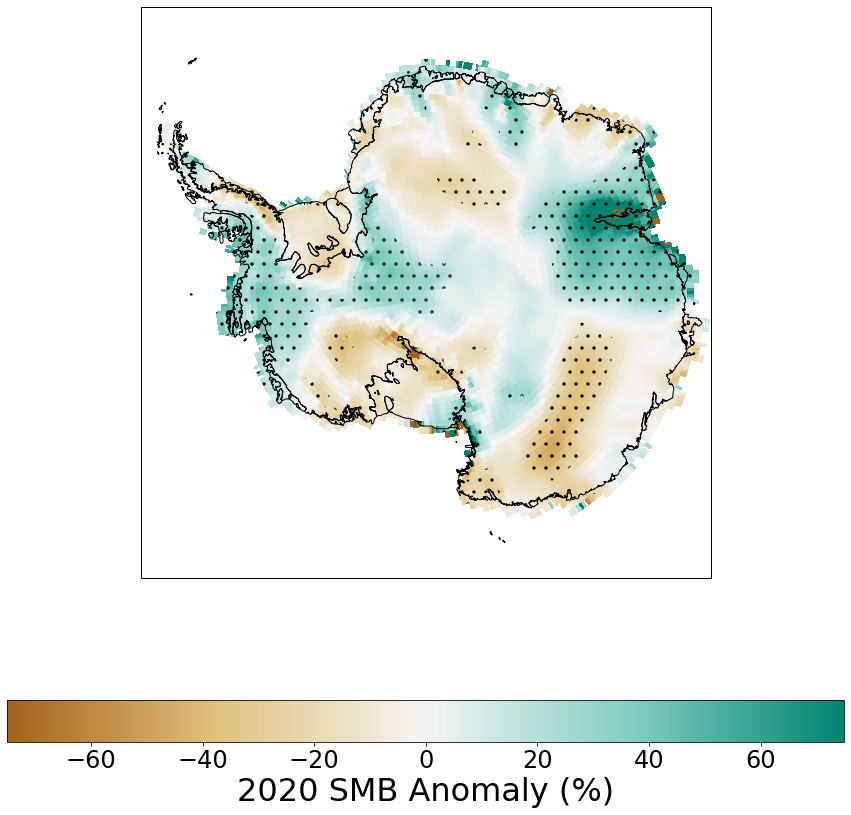

In [7]:
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(15, 15))

# Plot SMB
# colormap = RdBu_5.mpl_colormap
colormap = BrBG_5.mpl_colormap
mesh = plt.pcolormesh(np.linspace(-180, 180, len(ds['lon'])), ds['lat'].values, anomaly, cmap=colormap, transform=ccrs.PlateCarree(), vmin=-75, vmax=75)
plt.pcolor(np.linspace(-180, 180, len(ds['lon'])), ds['lat'].values, significant, hatch='.' , transform=ccrs.PlateCarree(), alpha=0.)
cbar = plt.colorbar(mesh, orientation = 'horizontal')
cbar.set_label("2020 SMB Anomaly (%)", size = 32)
cbar.ax.tick_params(labelsize=24)

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Save figure
plt.savefig('figures/2020_AIS_MERRA2_SMB_anomaly.pdf', format='pdf', dpi=100)

# Timeseries of monthly SMB (Gt/month)

In [8]:
# Determine 1981 - 2010 monthly average SMB
monthly_data_path = "/scratch/summit/erke2265/MERRA2_monthly/"

# Calculate 1981 - 2010 monthly smb
n_year = (2010 - 1981) + 1
n_month = 12

monthly_smb_1981_2010 = xr.Dataset(
    data_vars=dict(
        smb=(["month", "year"], np.zeros(n_year * n_month).reshape(n_month, n_year))
    )
)

# Append each years monthly smb
for count, year in enumerate(years[1:31]):
    monthly_smb = calc_monthly_grounded_smb(monthly_data_path, year)
    monthly_smb_1981_2010['smb'][:, count] = monthly_smb
    
# Calculate mean and standard deviation  
avg_smb_monthlyGT = monthly_smb_1981_2010['smb'].mean(dim='year')
std_smb_monthlyGT = monthly_smb_1981_2010['smb'].std(dim='year')

<Figure size 432x288 with 0 Axes>

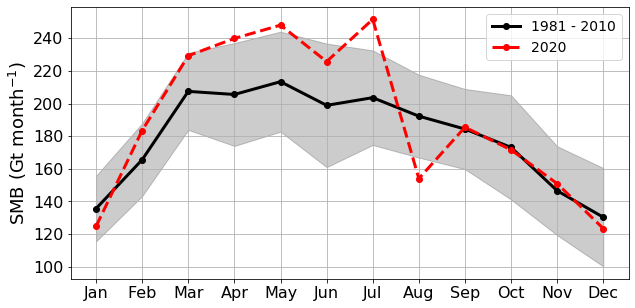

In [9]:
# Calculate 2020 monthly SMB
monthly_data_path = "/scratch/summit/erke2265/MERRA2_monthly/"
year = 2020
monthly_smb_2020 = calc_monthly_grounded_smb(monthly_data_path, year)

# Plot Timeseries
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov', 'Dec']
plt.figure()
fig = plt.figure(figsize = (10, 5))
plt.plot(month, avg_smb_monthlyGT, 'ko-', linewidth=3, label='1981 - 2010')
plt.fill_between(month, avg_smb_monthlyGT - std_smb_monthlyGT, avg_smb_monthlyGT + std_smb_monthlyGT, \
                  facecolor = "black", color = "black", alpha = 0.2)
plt.plot(month, monthly_smb_2020.values, 'ro--', linewidth=3, label=str(year))
plt.grid()
plt.legend(fontsize=14)
plt.ylabel("SMB (Gt month$^{-1}$)", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figures/Monthly_SMB.pdf', format='pdf', dpi=100)

# Calculate monthly anomaly maps

In [10]:
# Mask
ais_mask = xr.open_dataset("data/AIS_basins_Zwally_MERRA2grid.nc")
ais_mask = ais_mask['Zwallybasins'] / ais_mask['Zwallybasins']
tmp = ds * ais_mask

# Settings
year_tgt = 2020
year_ref = np.arange(1981, 2010 + 1)
n_year = len(year_ref)
n_month = 12
n_lon = len(tmp['lon'])
n_lat = len(tmp['lat'])

# Calculate year_tgt monthly smb
tgt_year_monthly_smb = calc_monthly_smb(monthly_data_path, year_tgt) * ais_mask

# Calculate year_ref monthly smb
monthly_smb_ref = xr.Dataset(
    data_vars=dict(
        smb=(["year", "month", "lat", "lon"], np.zeros(n_year * n_month * n_lat * n_lon).reshape(n_year, n_month, n_lat, n_lon))
    )
)

# Calculate monthly means during the reference period.   
for count, year in enumerate(years[1:31]):
    monthly_smb_ref['smb'][count, :, :, :] = calc_monthly_smb(monthly_data_path, year) * ais_mask

mean_monthly_smb_ref = monthly_smb_ref['smb'].mean(dim='year')

/projects/erke2265/miniconda/envs/a3d/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


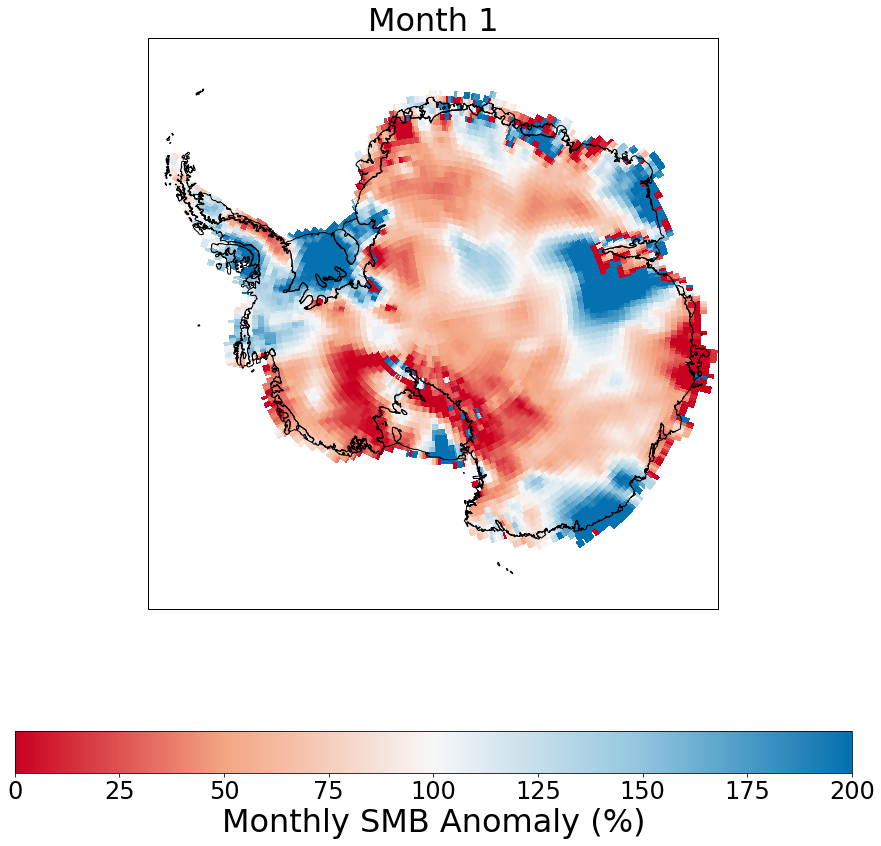

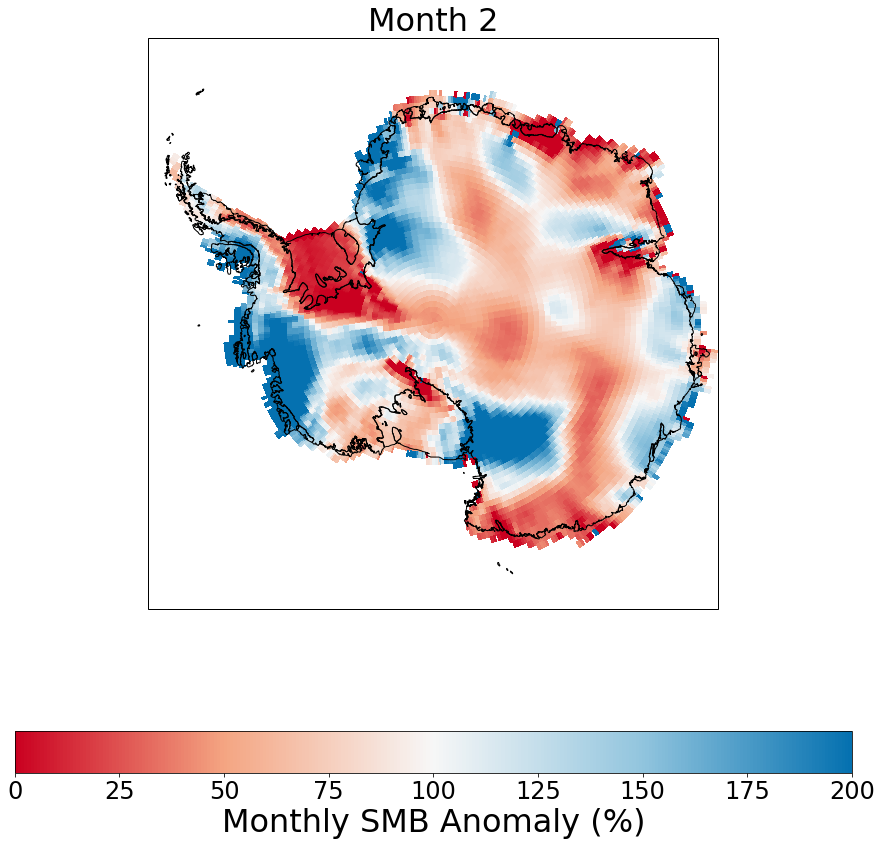

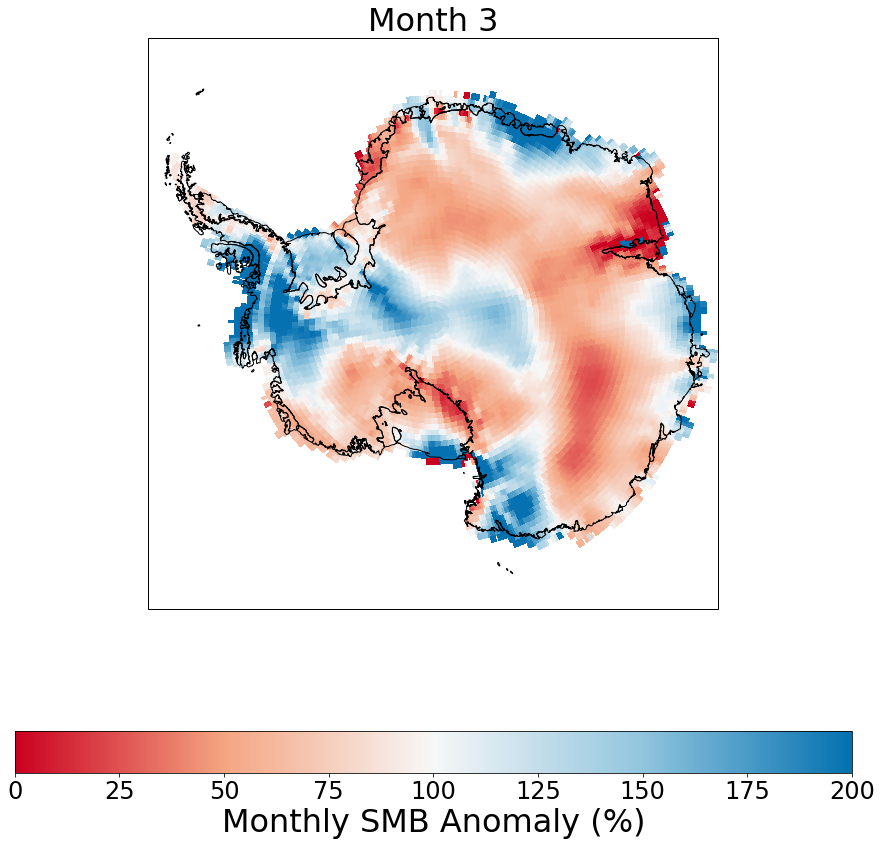

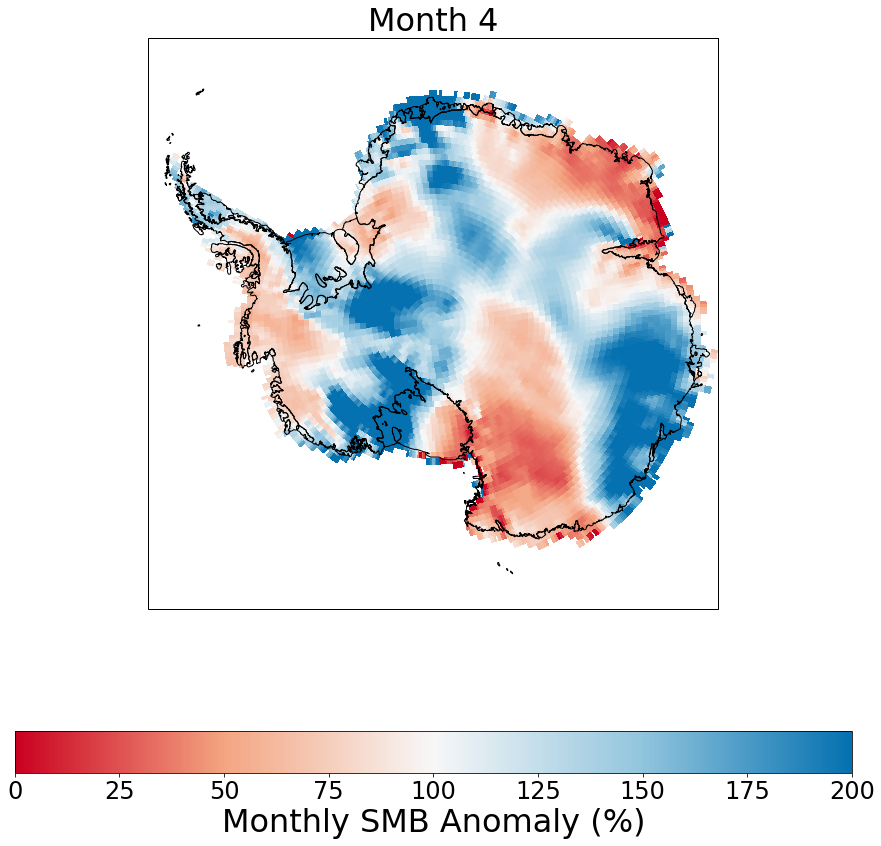

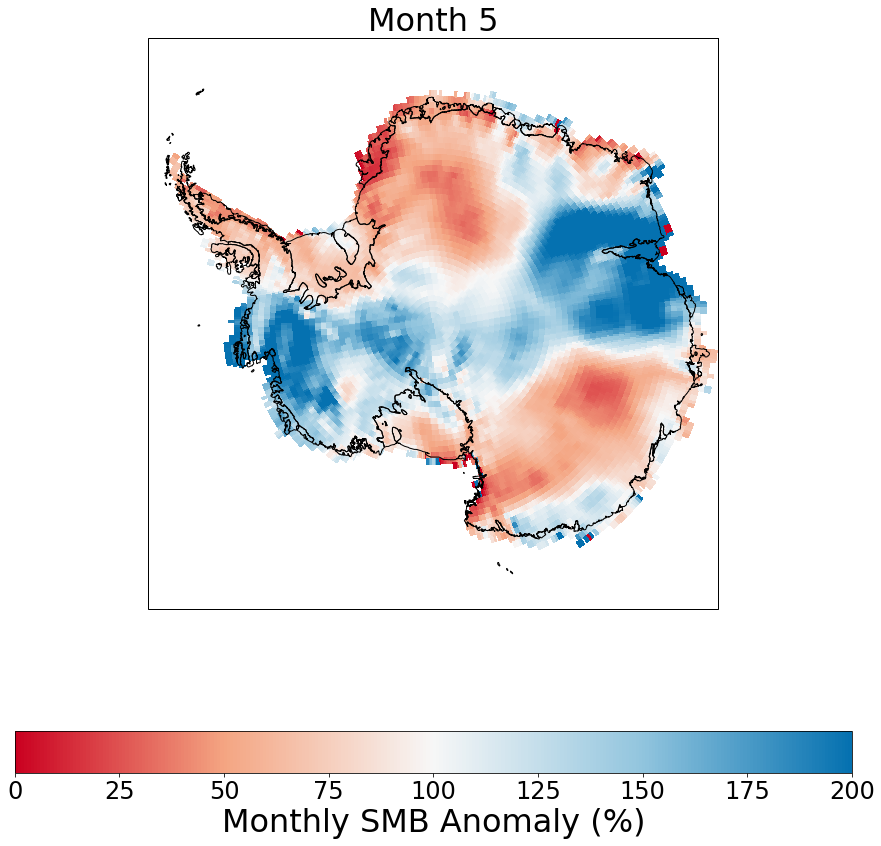

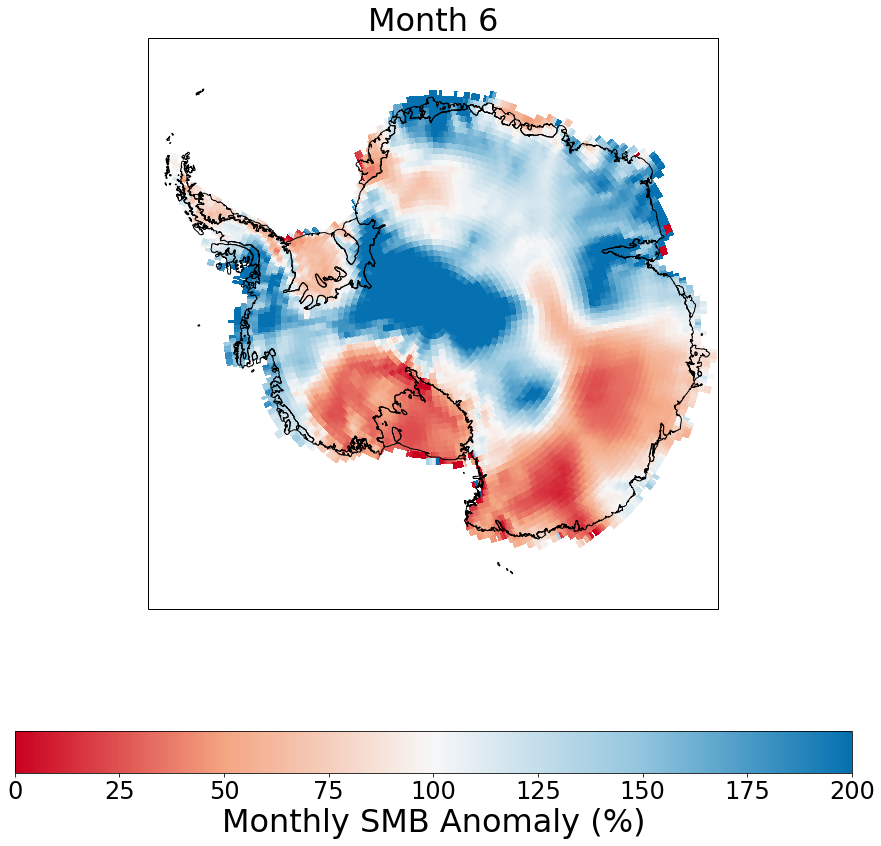

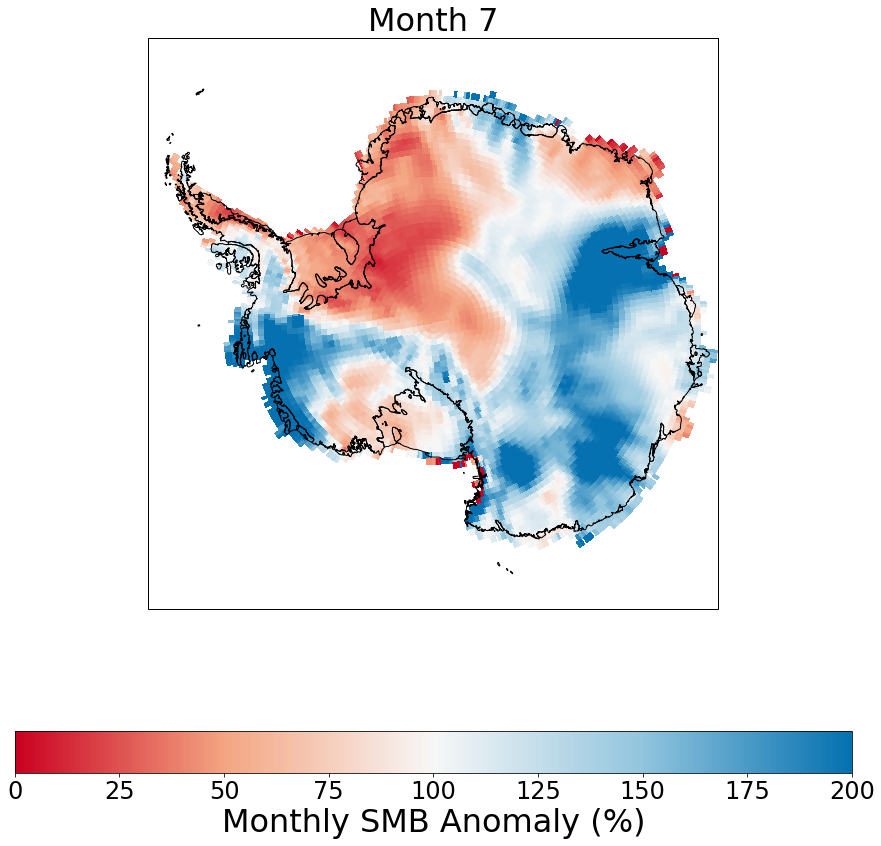

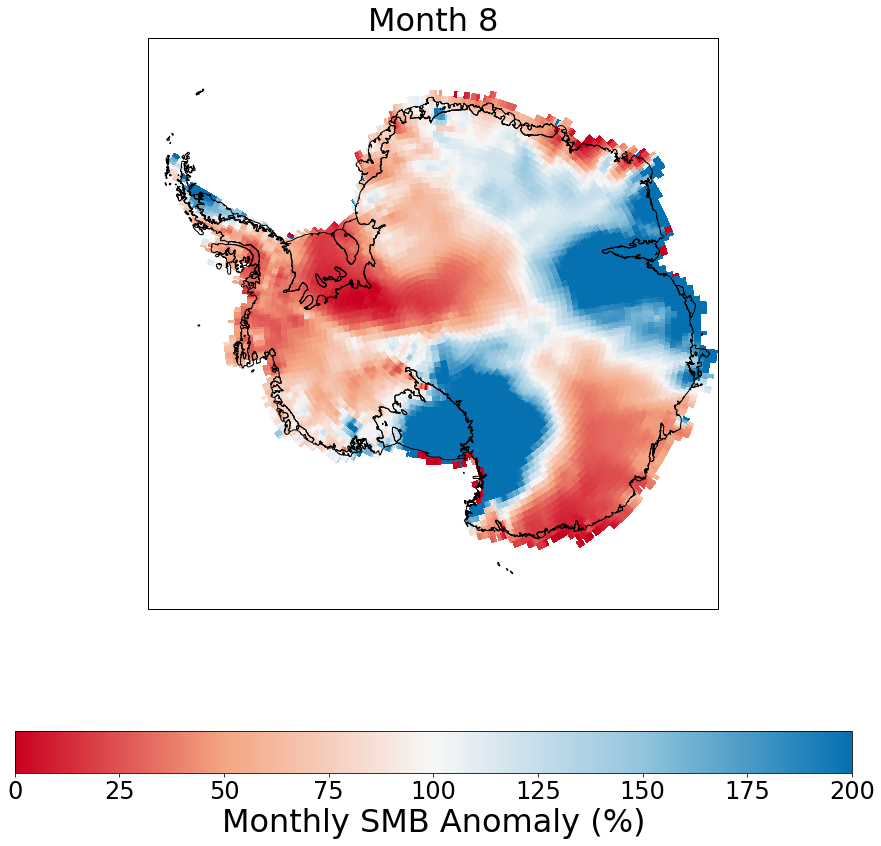

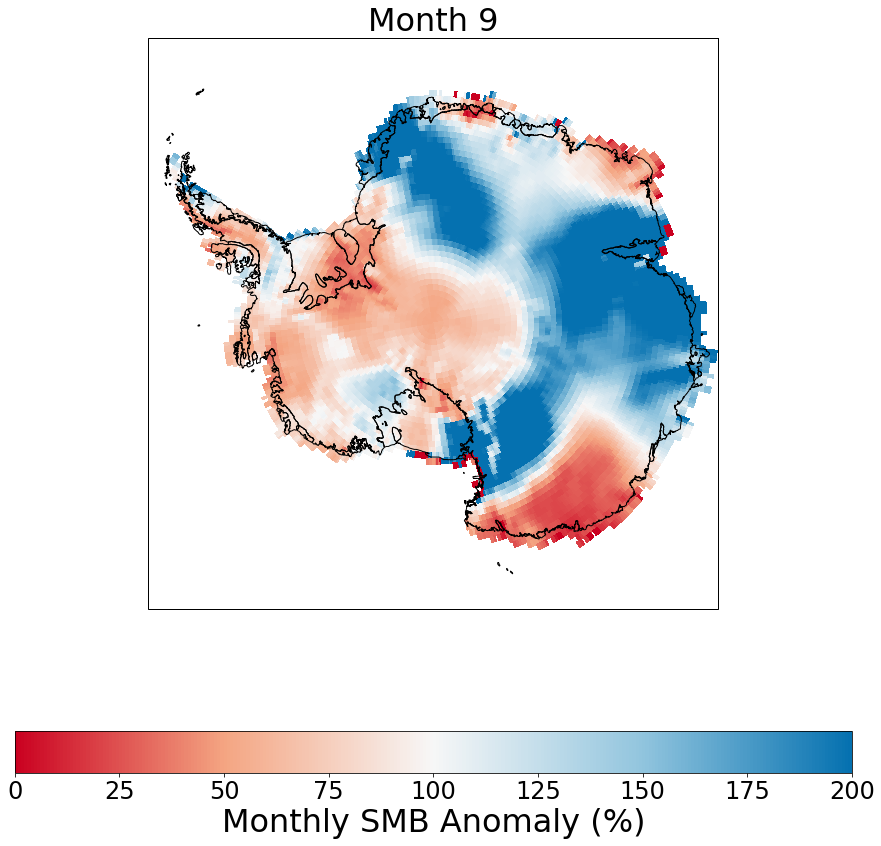

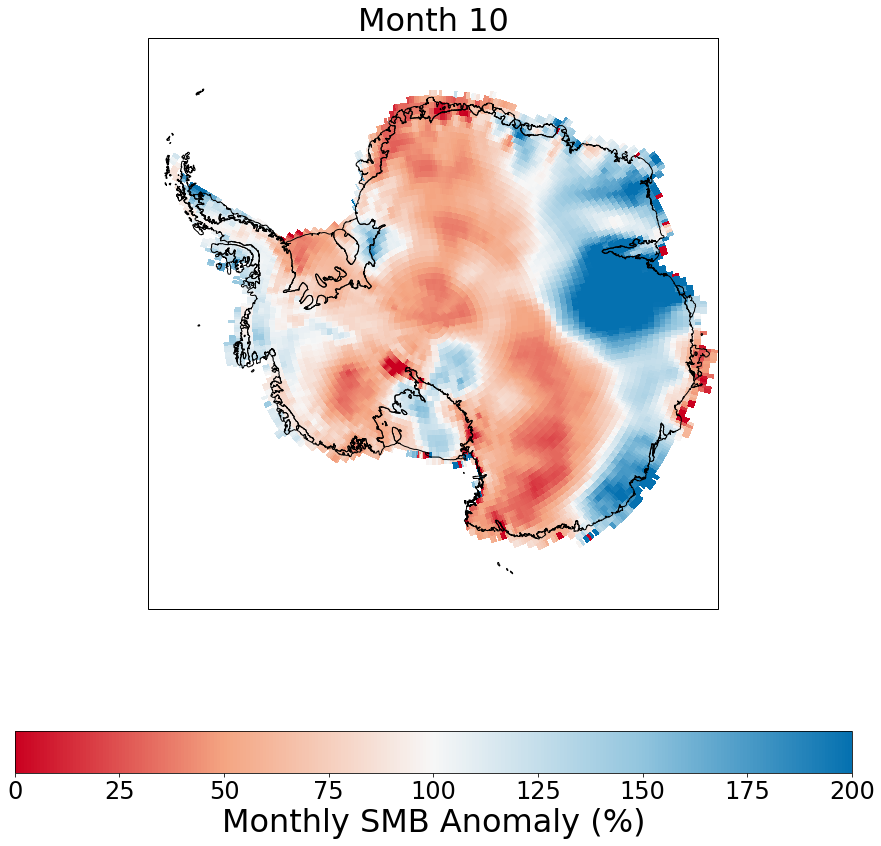

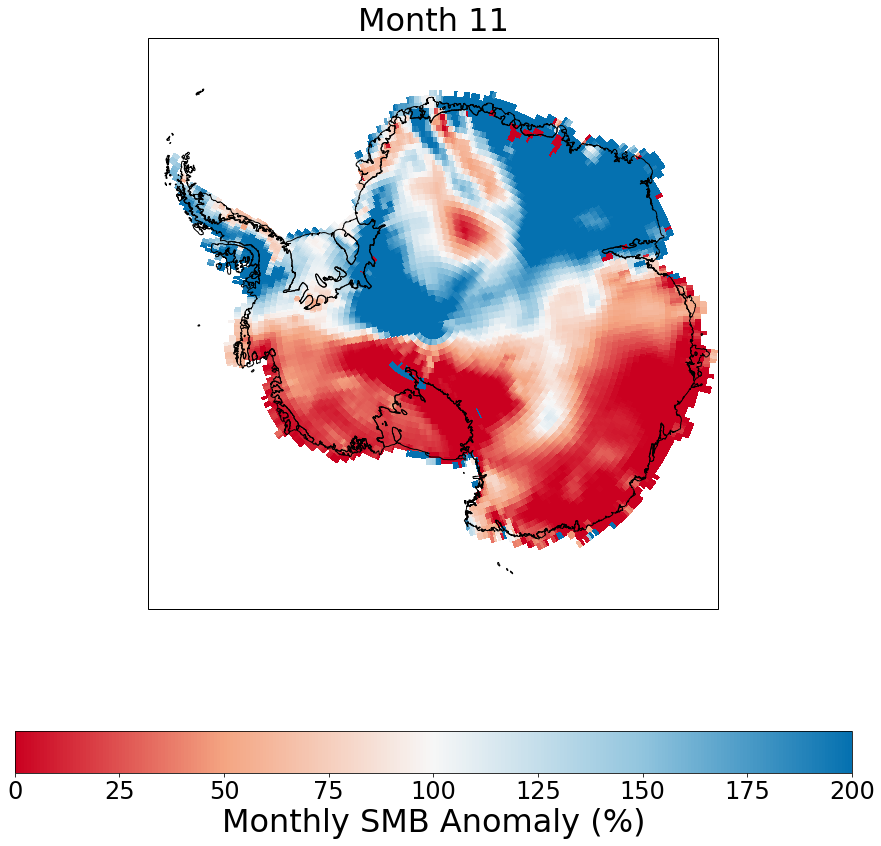

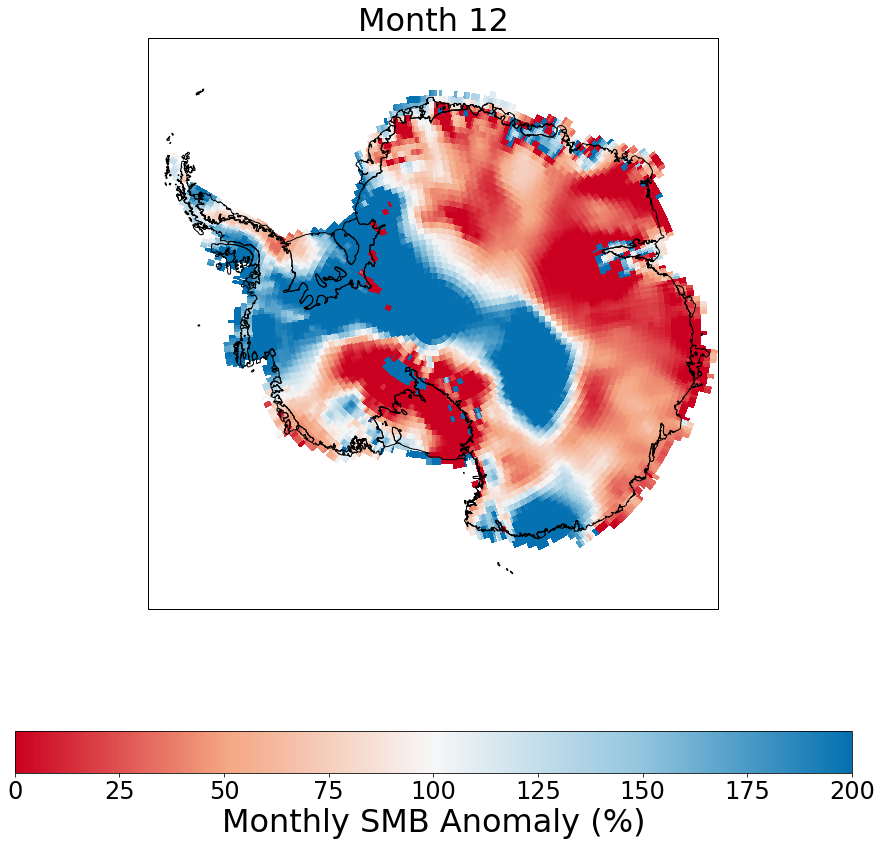

In [11]:
# Loop through each month in target year and plot and save monthly anomaly map
for j in range(0, n_month):
    ratio = tgt_year_monthly_smb[j,:,:] / mean_monthly_smb_ref[j,:,:] * 100

    # Generate figure 
    fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                            figsize=(15, 15))

    # Plot SMB
    colormap = RdBu_5.mpl_colormap
    mesh = plt.pcolormesh(np.linspace(-180, 180, len(ds['lon'])), ds['lat'].values, ratio, cmap=colormap, transform=ccrs.PlateCarree(), vmin=0, vmax=200)
    cbar = plt.colorbar(mesh, orientation = 'horizontal')
    cbar.set_label("Monthly SMB Anomaly (%)", size = 32)
    cbar.ax.tick_params(labelsize=24)
    plt.title("Month " + str(j + 1), fontsize=32)

    # Plot coastlines
    axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
    axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                          facecolor='none', edgecolor='black')

    # Save figure
    plt.savefig('figures/monthly_anomaly_maps/month_' + str(j + 1) + "_anomaly_map.pdf", format='pdf', dpi=100)